# Sampling origins across different cities and creating origin-destination pairs.

## Prerequisites
This repository builds on the python package OSMNx (v.2.0.1, https://osmnx.readthedocs.io/en/stable/). I recommend installing it via conda:
```
conda create -n ox -c conda-forge --strict-channel-priority osmnx
```
For sampling nodes based on city names two additional packages are required, namely geopy (v.2.3.1, https://geopy.readthedocs.io/en/stable/) and overpy (v.0.7, https://python-overpy.readthedocs.io/en/latest/)

```
pip install geopy
pip install overpy
```

For visualizing routes and geometry on maps I use the folium package (v.0.19.4, https://python-visualization.github.io/folium/latest/) that is included in the OSMNx package, but for creating static images of these visualizations the Selenium package is required (v.4.28.0, https://www.selenium.dev/documentation/)

```
pip install selenium
```

## This example
Cities are used as the basis to find random samples of intersections. The region and country names are nice to have, but they are not necessary.

In [1]:
# The workflow for analyzing the routes begins with coordinate points used as origin locations.
import pandas as pd

df = pd.DataFrame({
    "city_name": ["Umeå", "Dresden", "Barcelona"],
    "region": ["europe", "europe", "europe"],
    "country": ["Sweden", "Germany", "Spain"],
})

# To sample nodes from the cities we call use a method from sample_nodes.py
import node_sampling

df = node_sampling.get_random_nodes_for_all_cities(df,min_distance_km=1,sample_size=5)


display(df)

import os # for file operations

if not os.path.exists("example"):
    os.makedirs("example")
df.to_csv("example/city_samples.csv")


Random nodes for Umeå that are at least 1 km apart: [131929129, 286071727, 235711048, 151229069, 181289602]
Random nodes for Umeå: [131929129, 286071727, 235711048, 151229069, 181289602]
Node: 131929129
Random node coordinates for Umeå: 63.8477955, 20.3015189
Node: 286071727
Random node coordinates for Umeå: 63.829896, 20.2200845
Node: 235711048
Random node coordinates for Umeå: 63.8308534, 20.302052
Node: 151229069
Random node coordinates for Umeå: 63.8076472, 20.3377751
Node: 181289602
Random node coordinates for Umeå: 63.8257292, 20.2578009
Random nodes for Dresden that are at least 1 km apart: [30397959, 31353144, 2075222, 258056551, 85844679]
Random nodes for Dresden: [30397959, 31353144, 2075222, 258056551, 85844679]
Node: 30397959
Random node coordinates for Dresden: 51.0067858, 13.765929
Node: 31353144
Random node coordinates for Dresden: 51.0636456, 13.8305153
Node: 2075222
Random node coordinates for Dresden: 51.0381216, 13.7866486
Node: 258056551
Random node coordinates for 

,city_name,country,region,network_type,node_id,node_latlon
0,Umeå,Sweden,europe,drive,131929129,"(63.8477955, 20.3015189)"
1,Umeå,Sweden,europe,drive,286071727,"(63.829896, 20.2200845)"
2,Umeå,Sweden,europe,drive,235711048,"(63.8308534, 20.302052)"
3,Umeå,Sweden,europe,drive,151229069,"(63.8076472, 20.3377751)"
4,Umeå,Sweden,europe,drive,181289602,"(63.8257292, 20.2578009)"
5,Dresden,Germany,europe,drive,30397959,"(51.0067858, 13.765929)"
6,Dresden,Germany,europe,drive,31353144,"(51.0636456, 13.8305153)"
7,Dresden,Germany,europe,drive,2075222,"(51.0381216, 13.7866486)"
8,Dresden,Germany,europe,drive,258056551,"(51.0416335, 13.6335605)"
9,Dresden,Germany,europe,drive,85844679,"(50.9871767, 13.7983019)"


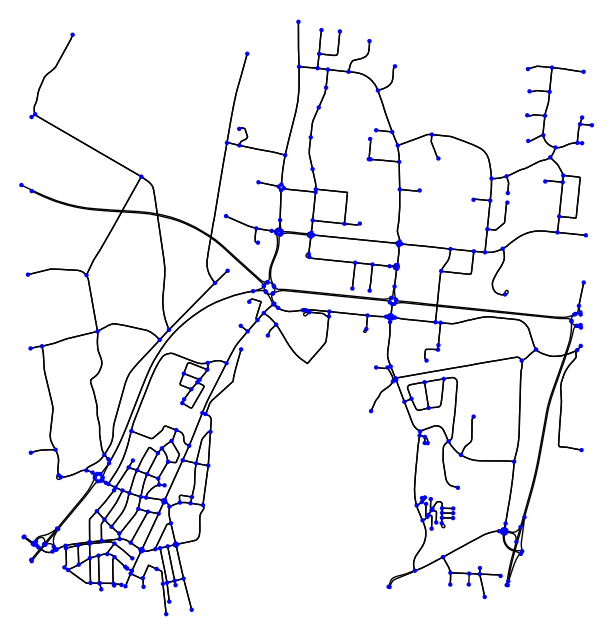

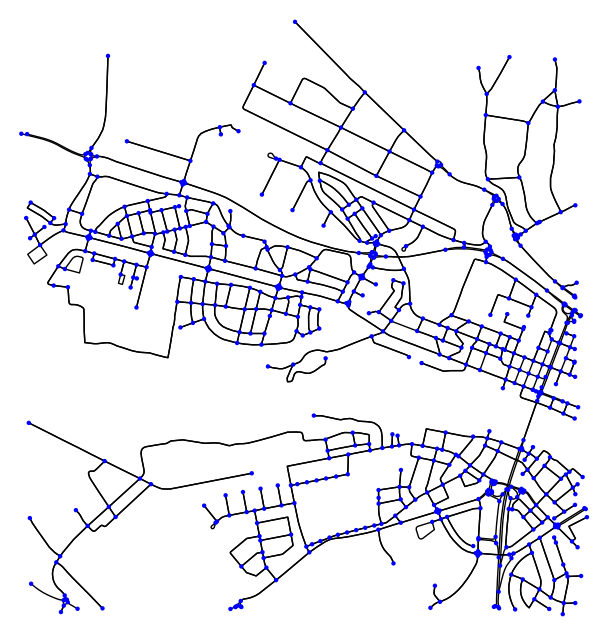

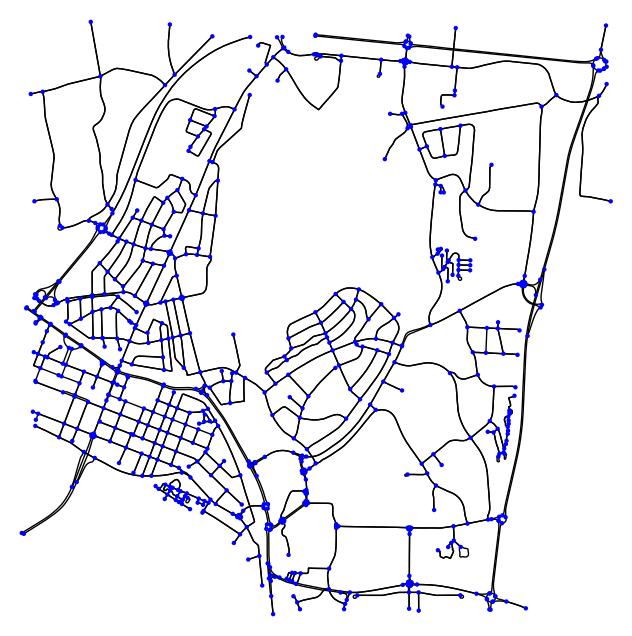

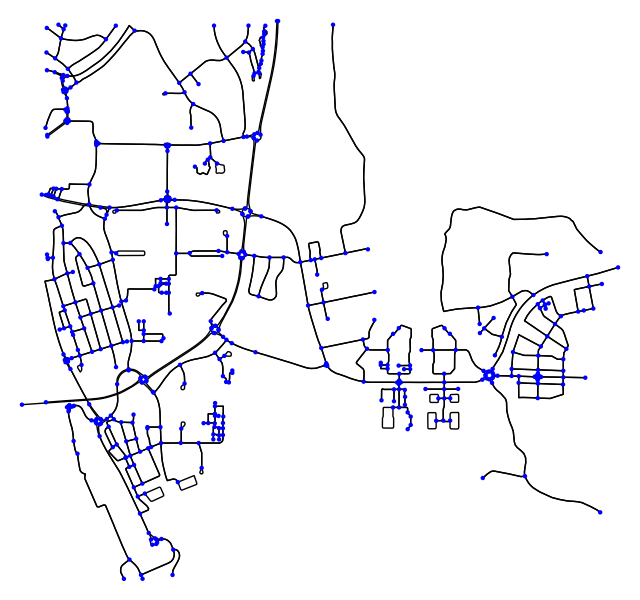

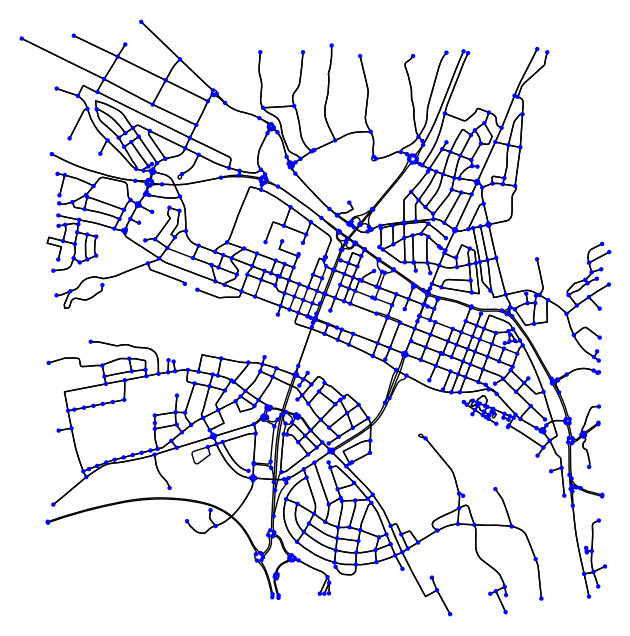

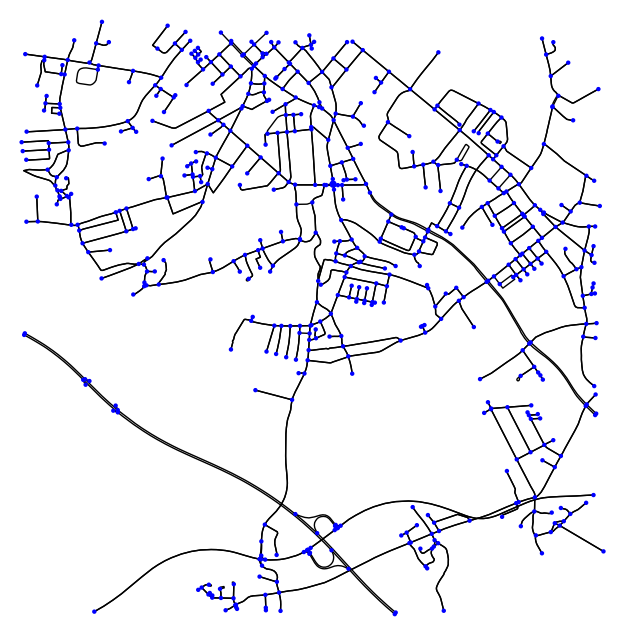

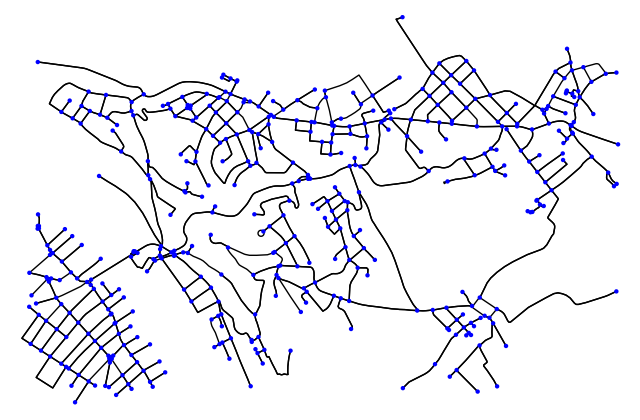

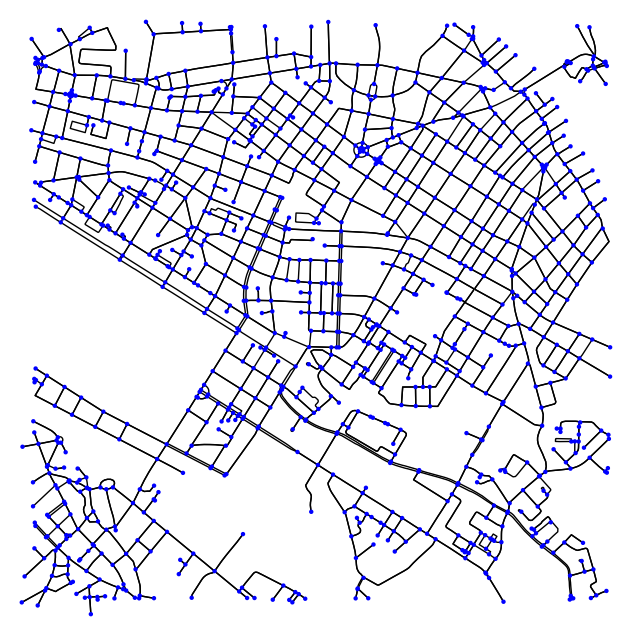

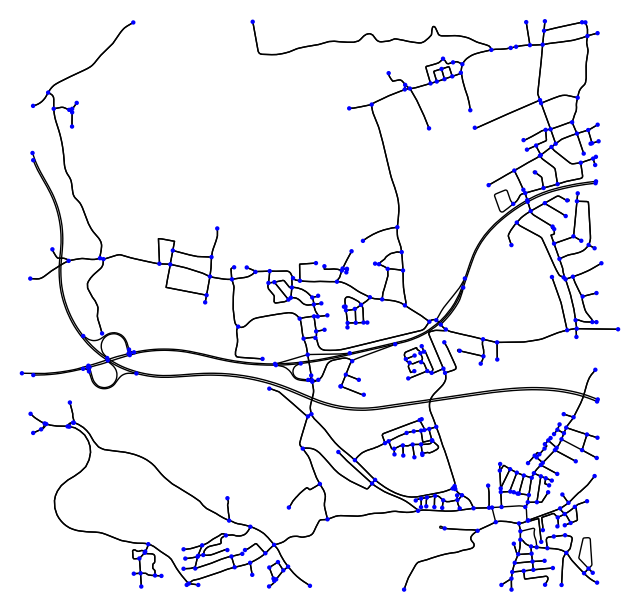

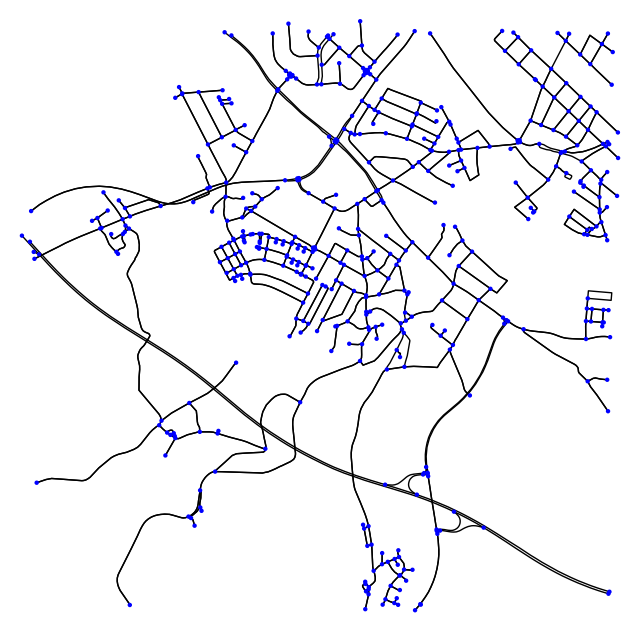

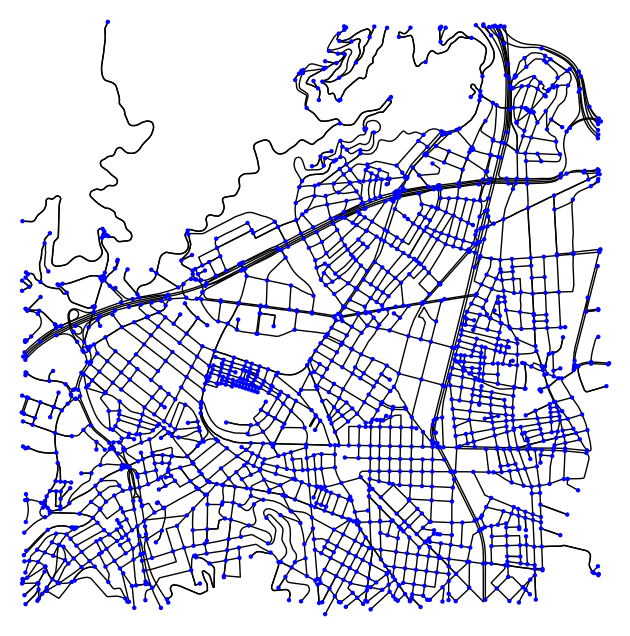

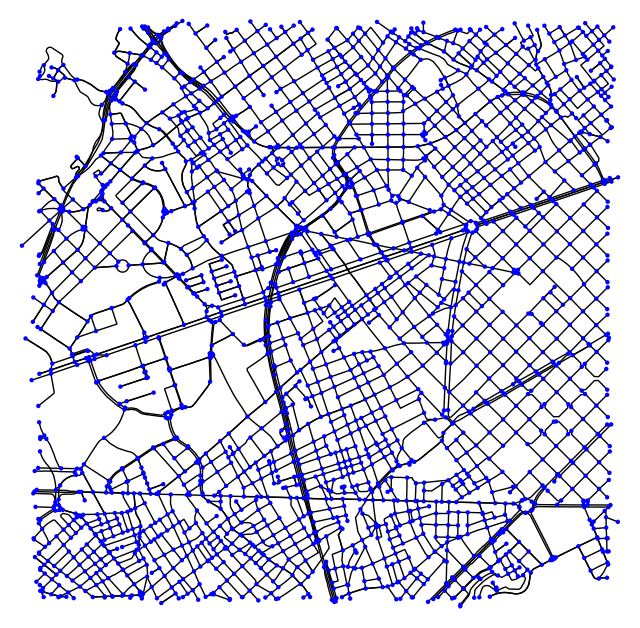

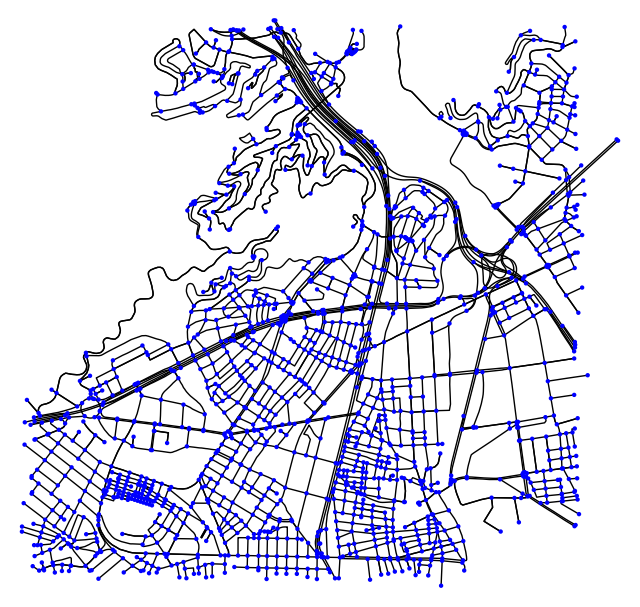

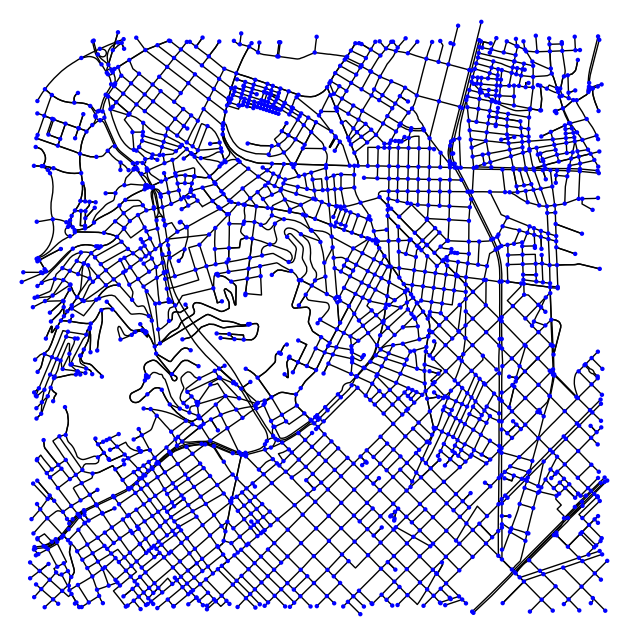

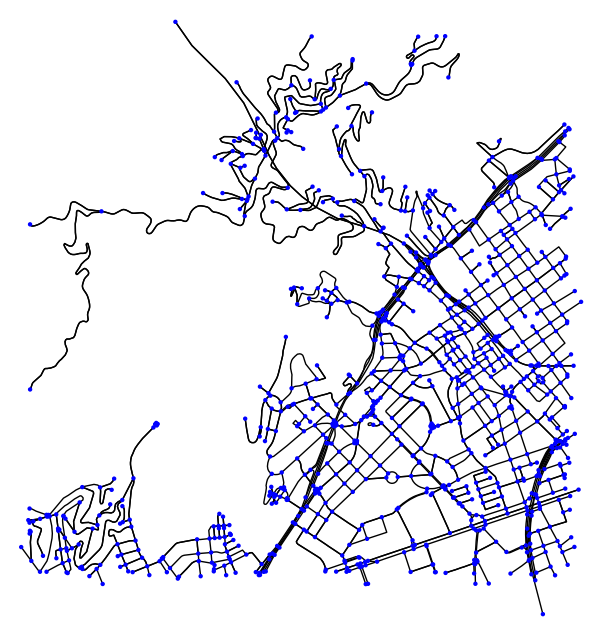

In [2]:
from origin_graph import origin_graph # for creating the origin graph object
import os # for file operations
import ast # for parsing string to tuple
import pandas as pd # for reading the csv file
import osmnx as ox # for plotting the graph
import matplotlib.pyplot as plt # for plotting the graphs
"""
The origin graph object requires the following parameters for instantiation:
# Required parameters:
- origin_point: The coordinate point of the city as a tuple (latitude, longitude)
- distance_from_point: The distance from the origin point in meters to the sides of a bounding box.
- city_name: The name of the city
- network_type: The type of network to use. The default is 'drive'.

# The following parameters are optional:
- remove_parallel: A boolean to remove parallel edges in the graph. The default is False.
- simplify: A boolean to simplify the graph. The default is False.
- edge_attr_diff: The attribute to differentiate edges in the graph when simplifying the graph. The default is None.

# Downloading a graph and weighing it can take some time. To speed up the process, you can load a graph from a file.
- save_graphml: The path to save the graphml file.
- load_graphml: The path to a graphml file to load.
"""

folder = "example/local_origin_graphs"

if not os.path.exists(folder):
    os.makedirs(folder)

df = pd.read_csv("example/city_samples.csv")

df['graph_path'] = None

for index, row in df.iterrows():
    latlon_point = ast.literal_eval(row['node_latlon'])
    og = origin_graph(origin_point=latlon_point, distance_from_point=2000,
                city_name=row["city_name"], network_type='drive', remove_parallel=True, simplify=True)
    
    graph_path = os.path.join(folder, f"{row['city_name']}_{row['node_id']}.graphml")
    og.save_graph(graph_path)

    # plot the origin graph to see if something is obviously wrong
    ox.plot_graph(og.graph, node_color='blue', node_size=10, edge_linewidth=1, edge_color='black', bgcolor='white')
    
    # Update the corresponding column in the dataframe
    df.at[index, f'graph_path'] = graph_path



df.to_csv("example/city_samples.csv",index=False)

In [3]:
# The next step is to add weights to the edges of the graph.

from origin_graph import origin_graph # for creating the origin graph object
import os # for file operations
import ast # for parsing string to tuple
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")

for index, row in df.iterrows():
    print(f"Adding weights to graph for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    # Adding the decision complexity weights may take some time.
    og.add_weights('decision_complexity')
    og.add_weights('deviation_from_prototypical')
    og.add_weights('node_degree')
    og.add_weights('instruction_equivalent')

    # We can print the edge weights to see which have been added.
    
    # Save the graph with the weights now added.
    og.save_graph(row['graph_path'])

Adding weights to graph for Umeå node id 131929129
0 edges left
Adding weights to graph for Umeå node id 286071727
1000 edges left
0 edges left
Adding weights to graph for Umeå node id 235711048
1000 edges left
0 edges left
Adding weights to graph for Umeå node id 151229069
1000 edges left
0 edges left
Adding weights to graph for Umeå node id 181289602
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 30397959
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 31353144
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 2075222
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 258056551
0 edges left
Adding weights to graph for Dresden node id 85844679
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 415718632
3000 edges left
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 511123386
4000 edges left
3

In [ ]:
from origin_graph import origin_graph # for creating the origin graph object
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")

origins_od_pair_data = []
for index, row in df.iterrows():
    print(f"Creating od-pairs for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    """
    Parameters:
    - min_distance: The minimum distance in meters between the origin and destination points in great circle distance.
    - max distance: The maximum distance in meters between the origin and destination points in great circle distance.
    - sample_size: The number of origin-destination pairs to sample.

    Return: a dataframe with each row corresponding to an origin-destination pair.
    """
    og.create_od_pairs(min_radius=1000, max_radius=1500, sample_size=144)
    od_pair_data = og.get_od_pair_data()
    origins_od_pair_data.append(od_pair_data)

origin_od_pairs = pd.concat(origins_od_pair_data)
print(f"Number of origin-destination pairs: {len(origin_od_pairs)} in the dataset.")
print(origin_od_pairs.head(n=2))
origin_od_pairs.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)



In [5]:
import post_processing
import pandas as pd
od_pair_data = pd.read_json("example/origin_od_pairs.json")

od_pair_data = post_processing.label_length_outliers(od_pair_data)
od_pair_data = post_processing.label_gridlike_groups(od_pair_data)

# Before normalizing the complexity, we need to remove the length outliers.
od_pair_data = od_pair_data[od_pair_data['length_outliers'] == False]
od_pair_data = post_processing.normalize_complexity(od_pair_data)

# The od-pair data contains lists and dictionaries that are not easily saved to a csv file, so we store it as a json file.
# Still, there some columns that need to be serialized to strings such as shapely polygon objects.
od_pair_data.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)

max complexity: 120 sum of columns: 75243, mean: 50.29612299465241, median: 49.0
max complexity: 86 sum of columns: 62264, mean: 41.62032085561497, median: 40.0
max complexity: 1.0 sum of columns: 627.025, mean: 0.41913435828877005, median: 0.4083333333333333
max complexity: 0.7166666666666667 sum of columns: 518.8666666666667, mean: 0.3468360071301248, median: 0.3333333333333333


od-pairs before removing length outliers 1496
od-pairs after removing length outliers 1496


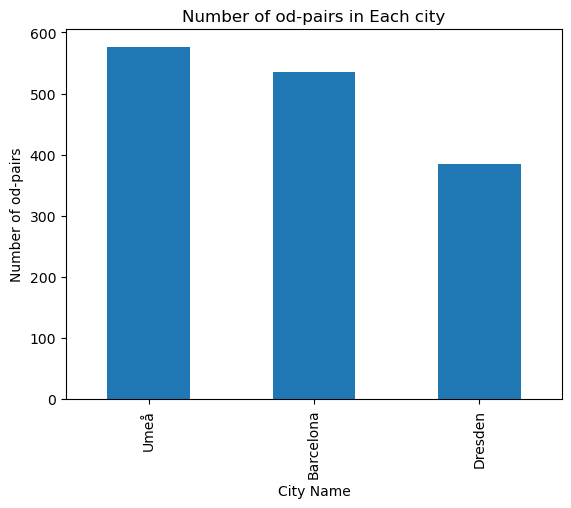

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

od_pair_data = pd.read_json("example/origin_od_pairs.json")
print(f"od-pairs before removing length outliers {len(od_pair_data)}")
od_pair_data = od_pair_data[od_pair_data['length_outliers'] == False]
print(f"od-pairs after removing length outliers {len(od_pair_data)}")

od_pair_data['closest_strongest_lag'] = abs(od_pair_data['closest_strongest_lag'])

od_pair_data = od_pair_data.sort_values(by="closest_strongest_lag", ascending=True)


city_counts = od_pair_data['city_name'].value_counts()
city_counts.plot(kind='bar')
plt.xlabel('City Name')
plt.ylabel('Number of od-pairs')
plt.title('Number of od-pairs in Each city')
plt.show()